Copyright (C) 2022 Project Group 127

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License version 3 as
published by the Free Software Foundation.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program. If not, see <https://www.gnu.org/licenses/>.

# Imports

Import the correct packages for running the classification models.

In [4]:
import pandas
import numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import (
    plot_confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    plot_roc_curve,
)

# Load the data

Also check out the first 10 lines of the loaded data.

In [5]:
api_data = pandas.read_csv("../../data/API/api_dataset_professional_games_better.csv", sep=",")
api_data.head()

,match_id,match_result,1_antimage,2_axe,3_bane,4_bloodseeker,5_crystal_maiden,6_drow_ranger,7_earthshaker,8_juggernaut,...,radiant_str,radiant_int,radiant_agi,radiant_melee,radiant_ranged,dire_str,dire_int,dire_agi,dire_melee,dire_ranged
0,5792362494,1,0,0,0,0,0,0,0,0,...,0.2,0.4,0.4,0.2,0.8,0.2,0.6,0.2,0.2,0.8
1,5794821137,-1,0,0,0,-1,1,0,0,0,...,0.4,0.4,0.2,0.4,0.6,0.4,0.4,0.2,0.6,0.4
2,5790226407,1,0,0,0,0,0,0,0,0,...,0.2,0.2,0.6,0.4,0.6,0.6,0.2,0.2,0.6,0.4
3,5790375758,1,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.4,0.4,0.2,0.6,0.4
4,5790649968,-1,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.8,0.0,0.2,0.8,0.2


# Seperate full dataset into features and class

The features are put in the "x" variable, the class in the "y" variable.  
Also check the contents of the "x" and "y" variables.

In [6]:
x = api_data.iloc[:,2:]
y = api_data["match_result"]
x.head()

,1_antimage,2_axe,3_bane,4_bloodseeker,5_crystal_maiden,6_drow_ranger,7_earthshaker,8_juggernaut,9_mirana,11_nevermore,...,radiant_str,radiant_int,radiant_agi,radiant_melee,radiant_ranged,dire_str,dire_int,dire_agi,dire_melee,dire_ranged
0,0,0,0,0,0,0,0,0,0,0,...,0.2,0.4,0.4,0.2,0.8,0.2,0.6,0.2,0.2,0.8
1,0,0,0,-1,1,0,0,0,0,0,...,0.4,0.4,0.2,0.4,0.6,0.4,0.4,0.2,0.6,0.4
2,0,0,0,0,0,0,0,0,0,1,...,0.2,0.2,0.6,0.4,0.6,0.6,0.2,0.2,0.6,0.4
3,0,0,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.4,0.4,0.2,0.6,0.4
4,0,0,0,0,0,0,0,0,0,0,...,0.4,0.6,0.0,0.4,0.6,0.8,0.0,0.2,0.8,0.2


In [7]:
print(y)

0        1
1       -1
2        1
3        1
4       -1
        ..
12381    1
12382   -1
12383   -1
12384   -1
12385    1
Name: match_result, Length: 12386, dtype: int64


# Split the data into test, validation and training sets

We split the full dataset into a test set of 2000.  
And a validation set of 2000.  
The remainder is used for training.

Names:
* x_test & y_test
* x_val & y_val
* x_train & y_train

In [8]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=2000)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=2000)
x_train.info()
x_test.info()
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 1888 to 6742
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 8.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1564 to 10637
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 10203 to 10012
Columns: 133 entries, 1_antimage to dire_ranged
dtypes: float64(10), int64(123)
memory usage: 2.0 MB


# Create a linear classification model and run grid search cross validation

We run grid search to find the optimal hyperparameter C.  
Once we have this optimal C we run our validation set to get a accuracy score for this model.

In [9]:
param_grid = {"kernel": ["linear"], "C": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]}
grid_linear = GridSearchCV(SVC(), param_grid, scoring="accuracy")
grid_linear.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_linear.best_params_)
print()
print("Grid scores on training set:")
print()
means = grid_linear.cv_results_["mean_test_score"]
for mean, params in zip(means, grid_linear.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'C': 4, 'kernel': 'linear'}

Grid scores on training set:

0.542 for {'C': 1, 'kernel': 'linear'}
0.543 for {'C': 2, 'kernel': 'linear'}
0.543 for {'C': 3, 'kernel': 'linear'}
0.543 for {'C': 4, 'kernel': 'linear'}
0.542 for {'C': 5, 'kernel': 'linear'}
0.543 for {'C': 6, 'kernel': 'linear'}
0.543 for {'C': 7, 'kernel': 'linear'}
0.543 for {'C': 8, 'kernel': 'linear'}
0.543 for {'C': 9, 'kernel': 'linear'}
0.543 for {'C': 10, 'kernel': 'linear'}
0.542 for {'C': 100, 'kernel': 'linear'}
0.542 for {'C': 1000, 'kernel': 'linear'}


In [10]:
print("Detailed classification report:")
print()
y_true_linear, y_pred_linear = y_val, grid_linear.predict(x_val)
print(classification_report(y_true_linear, y_pred_linear))
print()

Detailed classification report:

              precision    recall  f1-score   support

          -1       0.52      0.45      0.48       932
           1       0.57      0.63      0.60      1068

    accuracy                           0.55      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.55      0.54      2000




# Create a kNN classification model and run grid search cross validation

We run grid search to find the optimal hyperparameter k.  
Once we have this optimal k we run our validation set to get a accuracy score for this model.

In [11]:
knn = KNeighborsClassifier()
k_range = list(range(1, 101))
param_grid = dict(n_neighbors = k_range)

grid_knn = GridSearchCV(knn, param_grid, scoring="accuracy")
grid_knn.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_knn.best_params_)
print()
print("Grid scores on training set:")
print()
means = grid_knn.cv_results_["mean_test_score"]
for mean, params in zip(means, grid_knn.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'n_neighbors': 75}

Grid scores on training set:

0.511 for {'n_neighbors': 1}
0.497 for {'n_neighbors': 2}
0.510 for {'n_neighbors': 3}
0.507 for {'n_neighbors': 4}
0.509 for {'n_neighbors': 5}
0.505 for {'n_neighbors': 6}
0.508 for {'n_neighbors': 7}
0.500 for {'n_neighbors': 8}
0.503 for {'n_neighbors': 9}
0.497 for {'n_neighbors': 10}
0.505 for {'n_neighbors': 11}
0.500 for {'n_neighbors': 12}
0.506 for {'n_neighbors': 13}
0.504 for {'n_neighbors': 14}
0.513 for {'n_neighbors': 15}
0.505 for {'n_neighbors': 16}
0.512 for {'n_neighbors': 17}
0.511 for {'n_neighbors': 18}
0.517 for {'n_neighbors': 19}
0.515 for {'n_neighbors': 20}
0.518 for {'n_neighbors': 21}
0.511 for {'n_neighbors': 22}
0.515 for {'n_neighbors': 23}
0.508 for {'n_neighbors': 24}
0.509 for {'n_neighbors': 25}
0.507 for {'n_neighbors': 26}
0.511 for {'n_neighbors': 27}
0.511 for {'n_neighbors': 28}
0.514 for {'n_neighbors': 29}
0.511 for {'n_neighbors': 30}
0.514 for {'n_

In [12]:
print("Detailed classification report:")
print()
y_true_knn, y_pred_knn = y_val, grid_knn.predict(x_val)
print(classification_report(y_true_knn, y_pred_knn))
print()

Detailed classification report:

              precision    recall  f1-score   support

          -1       0.49      0.39      0.44       932
           1       0.55      0.65      0.60      1068

    accuracy                           0.53      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.53      0.52      2000




# Create a decision tree classification model and run grid search cross validation

We run grid search to find the optimal hyperparameters "criterion" and "splitter".  
Once we have these optimal hyperparameters we run our validation set to get a accuracy score for this model.

In [13]:
decision_tree = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"]}

grid_decision_tree = GridSearchCV(decision_tree, param_grid, scoring="accuracy")
grid_decision_tree.fit(x_train, y_train)

print("Best parameters set found on training set:")
print()
print(grid_decision_tree.best_params_)
print()
print("Grid scores on training set:")
print()
means = grid_decision_tree.cv_results_["mean_test_score"]
for mean, params in zip(means, grid_decision_tree.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'criterion': 'gini', 'splitter': 'best'}

Grid scores on training set:

0.511 for {'criterion': 'gini', 'splitter': 'best'}
0.509 for {'criterion': 'gini', 'splitter': 'random'}
0.501 for {'criterion': 'entropy', 'splitter': 'best'}
0.505 for {'criterion': 'entropy', 'splitter': 'random'}


In [14]:
print("Detailed classification report:")
print()
y_true_dt, y_pred_dt = y_val, grid_decision_tree.predict(x_val)
print(classification_report(y_true_dt, y_pred_dt))
print()

Detailed classification report:

              precision    recall  f1-score   support

          -1       0.48      0.48      0.48       932
           1       0.54      0.54      0.54      1068

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000




# Create a random forest classification model and run grid search cross validation



In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in numpy.linspace(start = 50, stop = 55, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [16]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [50, 51, 52, 53, 54, 55], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [17]:
rf_Model = RandomForestClassifier()

In [18]:
# Default value for cv is 5 for a 5-fold cross validation but I have played around with a few other integers 
# and have found 30 to be a nice balance of computational power and results. Changing the value for verbose just
# shows more messages regarding the computation time of the fold and how each parameter gets decided.
# n_jobs
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 30, verbose=3, n_jobs = 1)

In [19]:
rf_Grid.fit(x_train, y_train)

Fitting 30 folds for each of 192 candidates, totalling 5760 fits
[CV 1/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.518 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap

[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.516 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.516 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1,

[CV 14/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1,

[CV 8/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, m

[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.529 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.525 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_sa

[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.520 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.520 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.518 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.516 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 8/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.521 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, m

[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_sa

[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.527 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, m

[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.530 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.529 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.527 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.514 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.514 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, m

[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.518 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 26/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1,

[CV 14/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1,

[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.525 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.529 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, m

[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 26/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, m

[CV 20/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.520 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.521 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2,

[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, m

[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.529 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.525 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 26/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.527 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.520 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.498 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.513 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.516 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.513 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.525 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.534 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.534 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.516 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1,

[CV 8/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.504 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.507 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.507 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.536 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.532 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, m

[CV 2/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.536 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.507 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.500 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.518 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.514 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_sa

[CV 26/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.527 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.534 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.541 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.527 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.541 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.518 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.509 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.516 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.513 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.534 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.514 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.530 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1,

[CV 8/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.514 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.532 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.507 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.536 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.518 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, m

[CV 2/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.529 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.514 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.529 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_sa

[CV 26/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.530 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.552 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.545 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.529 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.509 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.530 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.505 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.511 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.539 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.511 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.513 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.516 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.538 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2,

[CV 8/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.504 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.514 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.536 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.539 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.514 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, m

[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.532 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.504 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.529 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.529 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.527 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.530 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.527 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.509 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.546 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.527 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.513 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.527 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.530 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.530 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.509 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.511 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.529 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1,

[CV 8/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.536 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.539 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, m

[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.536 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.514 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.511 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.539 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.536 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.529 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.530 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.509 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.539 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.534 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.538 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.516 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.541 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.509 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.529 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.507 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.536 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.520 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2,

[CV 8/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.514 total time=   0.1s
[CV 9/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.507 total time=   0.1s
[CV 10/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.518 total time=   0.1s
[CV 11/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.529 total time=   0.1s
[CV 12/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.529 total time=   0.1s
[CV 13/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.529 total time=   0.1s
[CV 14/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, m

[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.532 total time=   0.1s
[CV 3/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.536 total time=   0.1s
[CV 5/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.518 total time=   0.1s
[CV 6/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 7/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.536 total time=   0.1s
[CV 8/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.530 total time=   0.1s
[CV 27/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.530 total time=   0.1s
[CV 28/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.495 total time=   0.1s
[CV 30/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.530 total time=   0.1s
[CV 1/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.543 total time=   0.1s
[CV 2/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, m

[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 21/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.530 total time=   0.1s
[CV 22/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.534 total time=   0.1s
[CV 24/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.534 total time=   0.1s
[CV 25/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.534 total time=   0.1s
[CV 26/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2,

[CV 14/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.521 total time=   0.1s
[CV 15/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.532 total time=   0.1s
[CV 16/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.529 total time=   0.1s
[CV 17/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.534 total time=   0.1s
[CV 19/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.513 total time=   0.1s
[CV 20/30] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2,

[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.518 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.518 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_l

[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.525 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.525 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.529 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1,

[CV 27/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.527 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.513 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.518 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_lea

[CV 21/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.516 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.516 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_

[CV 15/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.521 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.520 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_

[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.529 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.525 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_l

[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.529 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.521 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 27/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.518 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_lea

[CV 21/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.527 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.520 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_

[CV 15/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.516 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_

[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.525 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_l

[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.518 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.525 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2,

[CV 27/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.516 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.527 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.516 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.518 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=2, max_features=auto, min_samples_lea

[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.516 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.527 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.509 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 9/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.518 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.529 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.518 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_l

[CV 3/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.511 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.529 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1,

[CV 27/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.521 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_lea

[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.516 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.516 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 9/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.518 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.525 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_l

[CV 3/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.518 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.525 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.518 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2,

[CV 27/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.520 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.534 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.513 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_lea

[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.527 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.530 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.527 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.525 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.523 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.520 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_

[CV 9/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.518 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.525 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.521 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_l

[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.546 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.539 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.539 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.507 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.529 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1

[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.527 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.505 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.520 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.504 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=52;, score=0.518 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf

[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.520 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.534 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.527 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.502 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.530 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.530 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 16/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.521 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.538 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.509 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.516 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 10/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.504 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.536 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.529 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.504 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=51;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.532 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.539 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.532 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.525 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.514 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=53;, score=0.514 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1

[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.538 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.513 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.523 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.543 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=55;, score=0.514 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf

[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.527 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.530 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.538 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.530 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.538 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.530 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 16/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.532 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.520 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.534 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.516 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 10/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.514 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.521 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.539 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.514 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.504 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=54;, score=0.532 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.543 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.521 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.525 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.529 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2

[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.541 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.516 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.520 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.521 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.518 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=52;, score=0.504 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf

[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.548 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.530 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.516 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.530 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 16/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.532 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.527 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.527 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.520 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.516 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.523 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=4, max_features=auto, min_samples_

[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.521 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.525 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.507 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.511 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=51;, score=0.529 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.525 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.536 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.539 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.536 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.500 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=53;, score=0.518 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1

[CV 28/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.545 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.495 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=54;, score=0.541 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.525 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.532 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=55;, score=0.521 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf

[CV 22/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.534 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.513 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.527 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.520 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.541 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.527 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 16/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.529 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.534 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.534 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.530 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.513 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=52;, score=0.530 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.536 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.536 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.518 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.514 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.504 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=54;, score=0.539 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.518 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.554 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.539 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.529 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.514 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.518 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2

[CV 28/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.534 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.509 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=51;, score=0.534 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.529 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.514 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=52;, score=0.514 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf

[CV 22/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 23/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.509 total time=   0.1s
[CV 24/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.541 total time=   0.1s
[CV 25/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.527 total time=   0.1s
[CV 26/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.530 total time=   0.1s
[CV 27/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=53;, score=0.523 total time=   0.1s
[CV 28/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 16/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.529 total time=   0.1s
[CV 17/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 18/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.527 total time=   0.1s
[CV 19/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.495 total time=   0.1s
[CV 20/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.523 total time=   0.1s
[CV 21/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=55;, score=0.516 total time=   0.1s
[CV 22/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 11/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.546 total time=   0.1s
[CV 12/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.521 total time=   0.1s
[CV 13/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.518 total time=   0.1s
[CV 14/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.514 total time=   0.1s
[CV 15/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=51;, score=0.543 total time=   0.1s
[CV 16/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_

[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.507 total time=   0.1s
[CV 5/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.529 total time=   0.1s
[CV 6/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.514 total time=   0.1s
[CV 7/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.532 total time=   0.1s
[CV 8/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.521 total time=   0.1s
[CV 9/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=53;, score=0.500 total time=   0.1s
[CV 10/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2

[CV 28/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.527 total time=   0.1s
[CV 29/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.498 total time=   0.1s
[CV 30/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=54;, score=0.527 total time=   0.1s
[CV 1/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 2/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.525 total time=   0.1s
[CV 3/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=55;, score=0.514 total time=   0.1s
[CV 4/30] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf

GridSearchCV(cv=30, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 51, 52, 53, 54, 55]},
             verbose=3)

In [20]:
print("Best parameters set found on training set:")
print()
print(rf_Grid.best_params_)
print()
print("Grid scores on training set:")
print()
means = rf_Grid.cv_results_["mean_test_score"]
for mean, params in zip(means, rf_Grid.cv_results_["params"]):
    print("%0.3f for %r" % (mean, params))

Best parameters set found on training set:

{'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 52}

Grid scores on training set:

0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 51}
0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 52}
0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 53}
0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 54}
0.523 for {'bootstrap': True, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split':

In [37]:
print("Detailed classification report:")
print()
y_true_rf, y_pred_rf = y_val, rf_Grid.predict(x_val)
print(classification_report(y_true, y_pred))
print()

accuracy = accuracy_score(y_true_rf, y_pred_rf)
print("LINEAR MODEL ACCURACY: " + str(accuracy))

Detailed classification report:

              precision    recall  f1-score   support

          -1       0.55      0.04      0.08       932
           1       0.54      0.97      0.69      1068

    accuracy                           0.54      2000
   macro avg       0.54      0.51      0.39      2000
weighted avg       0.54      0.54      0.41      2000


LINEAR MODEL ACCURACY: 0.5375


/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated i

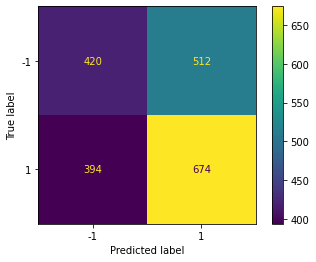

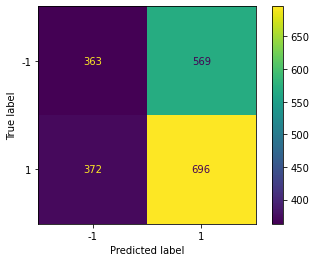

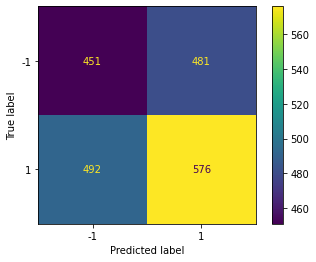

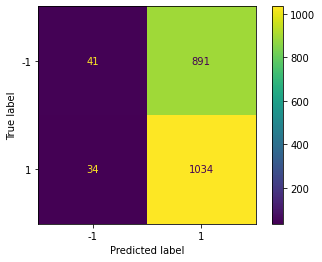

In [31]:
plot_confusion_matrix(grid_linear, x_val, y_val)
plot_confusion_matrix(grid_knn, x_val, y_val)
plot_confusion_matrix(grid_decision_tree, x_val, y_val)
plot_confusion_matrix(rf_Grid, x_val, y_val)
plt.show()

/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/jboom/miniconda3/envs/general/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Functio

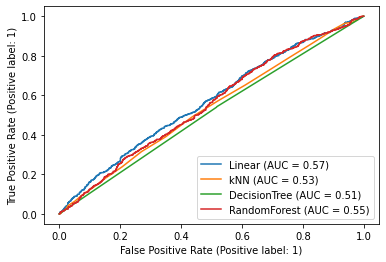

In [33]:
roc_linear = plot_roc_curve(grid_linear, x_val, y_val, name = "Linear")
plot_roc_curve(grid_knn, x_val, y_val, name = "kNN", ax = roc_linear.ax_)
plot_roc_curve(grid_decision_tree, x_val, y_val, name = "DecisionTree", ax = roc_linear.ax_)
plot_roc_curve(rf_Grid, x_val, y_val, name = "RandomForest", ax = roc_linear.ax_)
plt.show()

After multiple fits, I've found that the best parameters for the Random Forest model tuned with GridSearch crossvalidation are: bootstrap: False, max_depth: 4, min_samples_leaf: 2, min_samples_split: 2 and n_estimators: 53. Changing the amount of crossvalidations done in the range from 5-30 has a slight effect on the accuracy of the training model. The accuracy ranges from 0.537 to 0.552 in recent fits.